# Sequential Transition Analysis
The following notebook uses first-order markovian rules to determine forward transition probabilities for segments within calls produced by the individual OMGO, depending on the immediately preceding segment. See [Sainburg et al., (2020)](https://doi.org/10.1371/journal.pcbi.1008228) and [github.com/timsainb/avgn](https://github.com/timsainb/avgn_paper) for further detail on this process.

This notebook uses Python v3.8.13 (compared to v3.6 used in earlier notebooks).

In [1]:
from tqdm.auto import tqdm

In [2]:
import avgn

In [3]:
import pandas as pd
import numpy as np
from avgn.utils.paths import DATA_DIR, ensure_dir, FIGURE_DIR

In [4]:
DATASET_ID = "git_repos"

In [5]:
DT_ID = '2022-03-04_18-41-29'

In [6]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'OMGO_UMAP.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,indv,indvi,filename,group,location,sex,...,umap,call_unique_num,call_label,seg_pos_call,combi_unique_num,call_pos_combi,combi_label,seg_pos_combi,call_lab_simp,seg_pos
3,12.636243,12.656856,SH,727,OMGO,0,MBG OMGO Alert and Combo Series 1 200220 AM b,MBG,CRAWLEY,F,...,"[-5.741042, 9.573677]",301,SHSHNLDS,1,119,1,NLDS SHSHNLDS DSSHDS SHSHSHLH,3,SH-NL-DS,Second
11,13.294838,13.322906,SH,735,OMGO,0,MBG OMGO Alert and Combo Series 1 200220 AM b,MBG,CRAWLEY,F,...,"[-9.703462, 12.19955]",303,SHSHSHLH,2,119,3,NLDS SHSHNLDS DSSHDS SHSHSHLH,11,SH-LH,third
13,20.008098,20.031107,SH,737,OMGO,0,MBG OMGO Alert and Combo Series 1 200220 AM b,MBG,CRAWLEY,F,...,"[-5.8064704, 9.651678]",304,SHNLDS,0,120,0,SHNLDS DSSHDS SHLH,0,SH-NL-DS,first


### Plot barcodes for organization

In [8]:
import matplotlib.pyplot as plt
from avgn.visualization.barcodes_magpie import plot_sorted_barcodes, indv_barcode

In [9]:
seg_df.sort_values(by=['labels'], inplace = True)

labels ['DS' 'LH' 'SH']


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

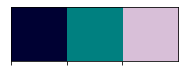

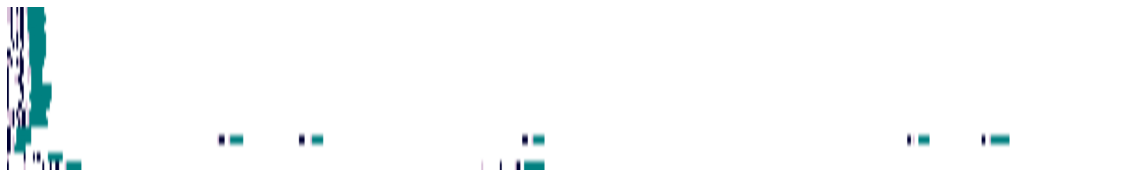

In [10]:
#only need the colours for DS, LH and SH segments (NL was removed from OMGO UMAP)
color = ['xkcd:very dark blue','teal','thistle'] 

all_dict = {}
for label in ["labels"]:
    print(label, seg_df[label].unique())
    color_lists, trans_lists, label_pal_dict, label_pal, label_dict = indv_barcode(
        seg_df,
        time_resolution=0.03,
        label="labels",
        pal=color,
    )
    
    all_dict[label] = {
    "label_pal_dict": label_pal_dict,
    "label_dict": label_dict,
    }
    
    fig, ax = plt.subplots(figsize=(20, 3))

    plot_sorted_barcodes(
        color_lists,
        trans_lists,
        max_list_len=600,
        seq_len=100,
        nex=200,
        figsize=(10, 4),
        ax=ax,
    )
    plt.show()


In [11]:
len(seg_df)

157

In [12]:
seg_df.sort_values(by=['ID'], inplace = True)

In [13]:
from avgn.visualization.projections_magpie import scatter_spec
from avgn.utils.general import save_fig

In [14]:
import seaborn as sns

### Combine UMAP & Transition Graph
- this plot shows the segment UMAP as well as the transition graph

In [15]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [16]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]

  0%|          | 0/157 [00:00<?, ?it/s]

In [17]:
from avgn.visualization.network_graph import plot_network_graph

In [ ]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)
ax1 = plt.subplot2grid(shape=(1, 24), loc=(0, 0), colspan=12)  ##1st Row
ax2 = plt.subplot2grid(shape=(1, 24), loc=(0, 12), colspan=12) #2nd row


color = ['xkcd:very dark blue','teal','thistle']

nex = -1
ax1.axis('off')
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    x_range = [-11.25,21.5],
    y_range = [-9, 23.75],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    ax = ax1,
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.labels.values,
        'alpha':1,
        's': 4,
        'show_legend': False,
        "color_palette": color,
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3, 

)

##Model
for label in ["labels"]:
    print(label)
    # plot graph
    elements = seg_df[label].values
    projections = np.array(list(seg_df['umap'].values))
    sequence_ids = np.array(seg_df["call_unique_num"])

    label_pal_dict = all_dict[label]['label_pal_dict']
    label_dict = all_dict[label]['label_dict']
    pal_dict = {i:label_pal_dict[j] for i,j in label_dict.items()}
    ax2.axis('off')
    plot_network_graph(
        elements, projections, sequence_ids, ax=ax2, pal_dict=pal_dict
    )

ax1.set_title("A)", loc='left', fontsize = 30)
ax2.set_title("B)", loc='left', fontsize = 30)
legend = ax2.legend(loc='lower left', labels = label_dict, fontsize=25)
handles = legend.legendHandles

#Create legend
for i, handle in enumerate(handles):
    handle.set_edgecolor(color[i]) # set_edgecolors
    handle.set_facecolor(color[i])
    #handle.set_alpha(0.7)

plt.tight_layout()

plt.show()


In [19]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [20]:
labscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.labels.values)

In [ ]:
labscore

In [23]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.labels.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.labels.values))

In [ ]:
KWlab = kruskal(samples, chance_samples)
KWlab